In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

from fastai.conv_learner import *
from fastai.dataset import *

In [5]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

In [6]:
PATH = Path('/mnt/samsung_1tb/Data/fastai/pascal/pascal_direct')
trn_j = json.load((PATH/'pascal_train2007.json').open())
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'


In [7]:

#images: is list of {file_name, height, width, id}
#annotations:[{"segmentation":[[155,96,155,270,351,270,351,96]],"area":34104,"iscrowd":0,"image_id":12,"bbox":[155,96,196,174],"category_id":7,"id":1,"ignore":0}
#categories:[{"supercategory":"none","id":1,"name":"aeroplane"}
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
#supercatgories in json file are all None
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [8]:
#note slightly different file setup to fastai path (train instead of VOCdevkit
JPEGS = 'train/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [9]:
#reuse functions from pascal, addmitedly I just copied and pasted these functions from the pascal_multi.ipynb
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [10]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [11]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

### Multi class classification

In [12]:
MC_CSV = PATH/'tmp/mc.csv'

In [13]:
#get image id 12 from this dict -returns bbox and category id
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [14]:
cats[7]

'car'

In [15]:
#for each image we dont want to repeat same labels
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
#change from list to space sep string
mcs = [' '.join(str(p) for p in o) for o in mc]

In [16]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn', 'clas'])
df.to_csv(MC_CSV, index=False)
df.head(n=2)

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fn</th>
      <th>clas</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>000012.jpg</td>
      <td>car</td>
    </tr>
    <tr>
      <th>1</th>
      <td>000017.jpg</td>
      <td>horse person</td>
    </tr>
  </tbody>
</table>
</div>

In [17]:

f_model = resnet34
sz = 224
bs = 64

In [18]:
tfms = tfms_from_model(f_model, sz, crop_type= CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, bs, tfms=tfms)

In [19]:
md.classes


['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

data: training data for model, models: model architectures to base learner

NB we need to use ConvLearner.pretrained rater than ConvLearner as f_model is not populated

where pretrained calls ConvnetBuilder to build a model with self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

In [21]:

learn = ConvLearner.pretrained(f=f_model, data=md)
type(learn)

fastai.conv_learner.ConvLearner

In [23]:
learn.opt_fn = optim.Adam

<p>Failed to display Jupyter Widget of type <code>HBox</code>.</p>
<p>
  If you're reading this message in the Jupyter Notebook or JupyterLab Notebook, it may mean
  that the widgets JavaScript is still loading. If this message persists, it
  likely means that the widgets JavaScript library is either not installed or
  not enabled. See the <a href="https://ipywidgets.readthedocs.io/en/stable/user_install.html">Jupyter
  Widgets Documentation</a> for setup instructions.
</p>
<p>
  If you're reading this message in another frontend (for example, a static
  rendering on GitHub or <a href="https://nbviewer.jupyter.org/">NBViewer</a>),
  it may mean that your frontend doesn't currently support widgets.
</p>

epoch      trn_loss   val_loss   <lambda>   
    0      1.170474   4.744905   0.828005  



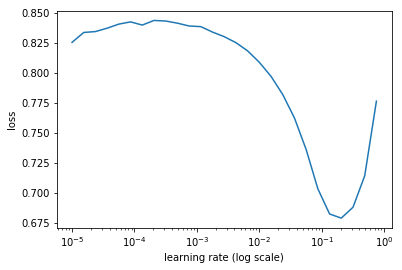

In [24]:
#loss depends on optimizer, ensure Adam is set above
learn.lr_find()
learn.sched.plot(0)

In [25]:
lr = 2e-2

In [26]:
learn.fit(lr, n_cycle=1, cycle_len=3, use_clr=(32,5))

<p>Failed to display Jupyter Widget of type <code>HBox</code>.</p>
<p>
  If you're reading this message in the Jupyter Notebook or JupyterLab Notebook, it may mean
  that the widgets JavaScript is still loading. If this message persists, it
  likely means that the widgets JavaScript library is either not installed or
  not enabled. See the <a href="https://ipywidgets.readthedocs.io/en/stable/user_install.html">Jupyter
  Widgets Documentation</a> for setup instructions.
</p>
<p>
  If you're reading this message in another frontend (for example, a static
  rendering on GitHub or <a href="https://nbviewer.jupyter.org/">NBViewer</a>),
  it may mean that your frontend doesn't currently support widgets.
</p>

epoch      trn_loss   val_loss   <lambda>   
    0      0.328151   0.136837   0.954132  
    1      0.176587   0.078733   0.974782  
    2      0.117937   0.074702   0.974775  



[0.07470181, 0.9747746363282204]

In [27]:
lrs = np.array([lr/100, lr/10, lr])

In [28]:
learn.freeze_to(-2)

<p>Failed to display Jupyter Widget of type <code>HBox</code>.</p>
<p>
  If you're reading this message in the Jupyter Notebook or JupyterLab Notebook, it may mean
  that the widgets JavaScript is still loading. If this message persists, it
  likely means that the widgets JavaScript library is either not installed or
  not enabled. See the <a href="https://ipywidgets.readthedocs.io/en/stable/user_install.html">Jupyter
  Widgets Documentation</a> for setup instructions.
</p>
<p>
  If you're reading this message in another frontend (for example, a static
  rendering on GitHub or <a href="https://nbviewer.jupyter.org/">NBViewer</a>),
  it may mean that your frontend doesn't currently support widgets.
</p>

 84%|████████▍ | 27/32 [00:04<00:00,  6.09it/s, loss=0.462]


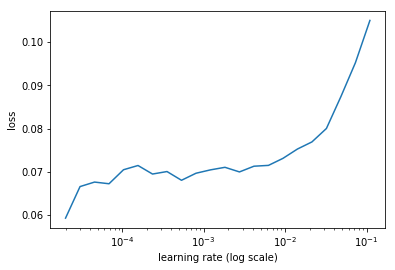

In [29]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [30]:
learn.fit(lrs/10, n_cycle=1, cycle_len=3, use_clr=(32,5))

<p>Failed to display Jupyter Widget of type <code>HBox</code>.</p>
<p>
  If you're reading this message in the Jupyter Notebook or JupyterLab Notebook, it may mean
  that the widgets JavaScript is still loading. If this message persists, it
  likely means that the widgets JavaScript library is either not installed or
  not enabled. See the <a href="https://ipywidgets.readthedocs.io/en/stable/user_install.html">Jupyter
  Widgets Documentation</a> for setup instructions.
</p>
<p>
  If you're reading this message in another frontend (for example, a static
  rendering on GitHub or <a href="https://nbviewer.jupyter.org/">NBViewer</a>),
  it may mean that your frontend doesn't currently support widgets.
</p>

epoch      trn_loss   val_loss   <lambda>   
    0      0.076265   0.080647   0.9747    
    1      0.052838   0.077694   0.974234  
    2      0.03718    0.076463   0.975503  



[0.0764628, 0.9755033105611801]

In [31]:
learn.save('mclas')


In [32]:
learn.load('mclas')

In [33]:
preds = learn.predict()
preds

array([[0.00003, 0.99975, 0.00008, ..., 0.00001, 0.00004, 0.00007],
       [0.00001, 0.00038, 0.     , ..., 0.47727, 0.00009, 0.00942],
       [0.00008, 0.00005, 0.9998 , ..., 0.00005, 0.00031, 0.00001],
       ...,
       [0.00706, 0.00509, 0.00004, ..., 0.00028, 0.00028, 0.00003],
       [0.     , 0.01134, 0.00017, ..., 0.00006, 0.00012, 0.00003],
       [0.00002, 0.00111, 0.0011 , ..., 0.0085 , 0.00053, 0.00213]], dtype=float32)

In [34]:
x,_ = next(iter(md.val_dl))
x = to_np(x)

ya: [ 1 14]
ya: [11 17]
ya: [2]
ya: [14]
ya: [14]
ya: [6]
ya: []
ya: [ 8 10]
ya: [2]
ya: [9]
ya: [15]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ya: [6]


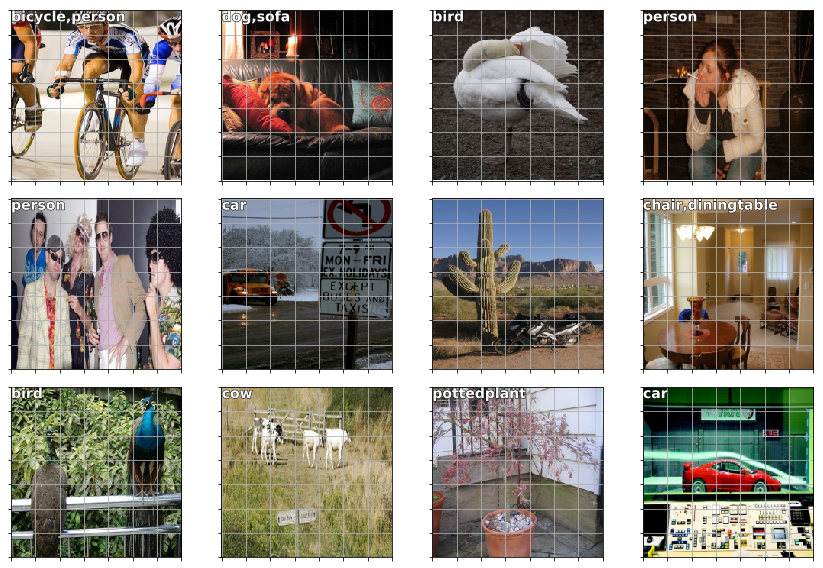

In [35]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    #Return the indices of the elements that are non-zero.
    ya = np.nonzero(preds[i]>0.4)[0]
    print(f'ya: {ya}')
    b = ','.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## Box per cell


In [36]:
#set up csv files
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

In [37]:
f_model = resnet34
sz = 224
bs = 64

#### timdavidlee notes:

Create Lookups and reference objects

mc - list of items found per image

mcs - list of items found per image, but the ID

id2cat - numeric value to category

cat2id - category to id

In [38]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k, v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])
mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [39]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

In [40]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

In [41]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)
df.head(n=2)

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fn</th>
      <th>bbox</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>000012.jpg</td>
      <td>96 155 269 350</td>
    </tr>
    <tr>
      <th>1</th>
      <td>000017.jpg</td>
      <td>61 184 198 278 77 89 335 402</td>
    </tr>
  </tbody>
</table>
</div>

In [42]:
#augmentations
aug_tfms = [RandomRotate(10, tfm_y = TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)]

In [43]:
tfms = tfms_from_model(f_model, sz, aug_tfms=aug_tfms, tfm_y=TfmType.COORD, crop_type=CropType.NO)
#regression for coords
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, bs, tfms=tfms, continuous=True)

In [44]:
def get_cmap(num_colr):
    colr_norm = mcolors.Normalize(vmin=0, vmax=num_colr-1)
    #The ScalarMappable makes use of data normalization before returning
    #RGBA colors from the given colormap.
    rgb_map = cmx.ScalarMappable(norm=colr_norm, cmap='Set3').to_rgba
    return rgb_map

In [45]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [46]:
def show_ground_truth(ax, im, bbox, clas=None, prs= None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:
        prs = [None]*len(bb)
    if clas is None:
        clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i, (b, c, pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None:
                txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None:
                txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [47]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y, self.y2[i]))

In [48]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [49]:
x, y = to_np(next(iter(md.val_dl)))
#TODO trace .ds - why doe we need dataset.ds?
x = md.val_ds.ds.denorm(x)

In [50]:
x_trn, y_trn = to_np(next(iter(md.trn_dl)))
x_trn = md.trn_ds.ds.denorm(x_trn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


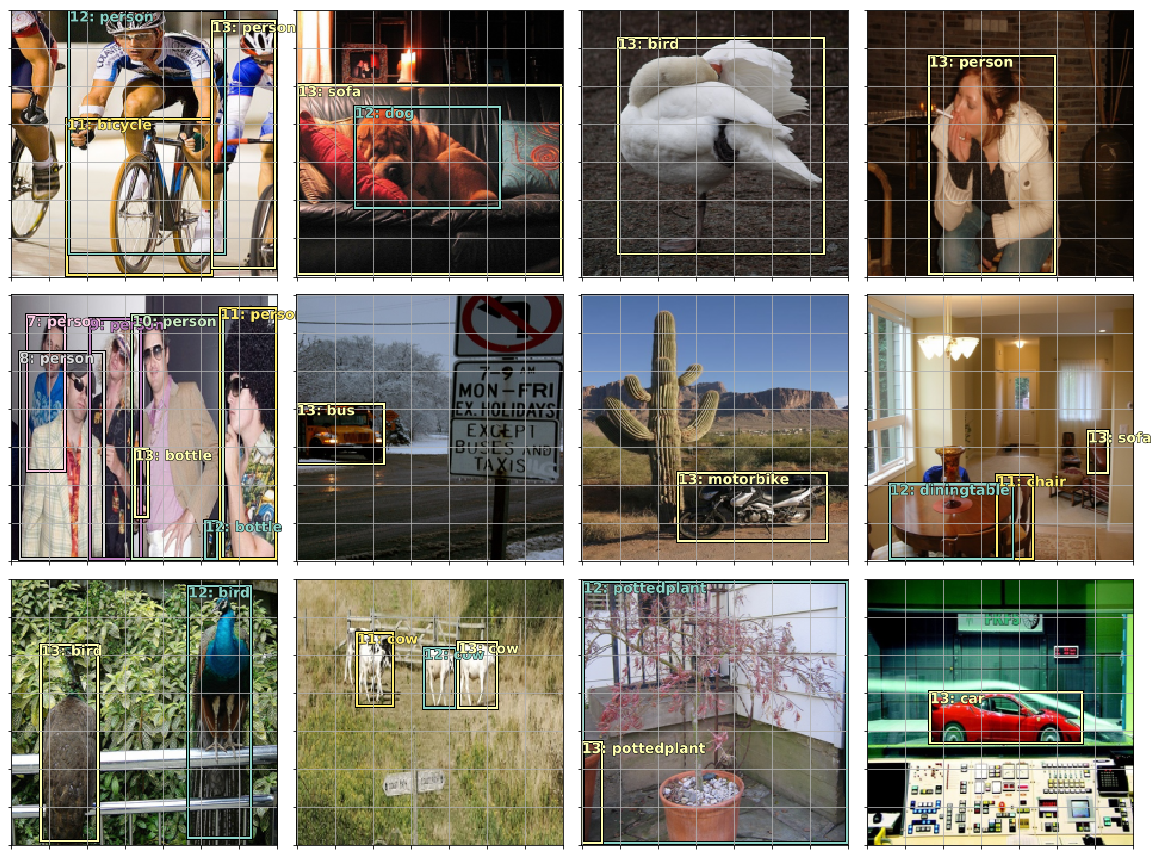

In [51]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Set up model
#### notes from timdavidlee

Make a model to predict what shows up in a 2x2 grid

anc_grid = how big of a square grid to make (subdivision)

anc_offset = center offsets

anc_x = x coordinates for centers

anc_y = y coordinates for centers

anc_ctrs - the actual coordinates for the grid centers

anc_sizes - size of the quadrants


In [52]:
anc_grid =4
k = 1 #scalar for out_channels, activations

In [53]:
anc_offset = 1/(anc_grid*2)
#linspace: Return evenly spaced numbers over a specified interval.
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
#tile(A, reps):Construct an array by repeating A the number of times given by reps.
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

In [54]:
anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])
#requires_grad: Boolean indicating whether the Variable has been created by a subgraph containing any Variable, that requires it.
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [55]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

(0, 1)

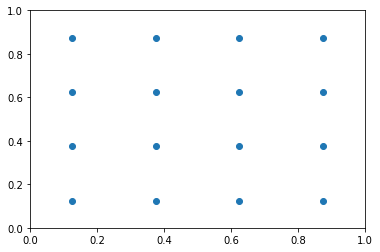

In [56]:
plt.scatter(anc_x, anc_y)
plt.xlim(0,1)
plt.ylim(0,1)

In [57]:
anchors[0]

Variable containing:
 0.1250
 0.1250
 0.2500
 0.2500
[torch.cuda.FloatTensor of size 4 (GPU 0)]

In [58]:
def hw2corners(ctr, hw):
    #cat: Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [59]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:, 2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [60]:
#number of classes including background
n_clas = len(id2cat)+1
#act is an abbreviation for activations?
n_act = k*(4+n_clas)

### Single Shot Multibox Detector

#### StdConv() 

Default stride = 2

conv -> relu-> batchnorm -> dropout

In [61]:
class StdConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, drop=0.1):
        super().__init__()
        #note we are using a 2d conv unlike prev where we replaced head with a 1d flattened conv
        #Conv2D args:
        #   in_channels (int): Number of channels in the input image
        #   out_channels (int): Number of channels produced by the convolution
        #   kernel_size (int or tuple): Size of the convolving kernel
        #   stride (int or tuple, optional): Stride of the convolution. Default: 1
        #   padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        #   dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
        #   groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        #   bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        #The mean and standard-deviation are calculated per-dimension over the mini-batches
        self.bn = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        
        data = F.relu(self.conv(x))
        data = self.bn(data)
        data = self.drop(data)
        return data

In [62]:
def flatten_conv(x,k):
    #batch size, layers, x, y
    bs, nf, gx, gy = x.size()
    #Permute the dimensions of this tensor to given params
    x = x.permute(0,2,3,1).contiguous()
    #view reshapes the tensor, -1 for where don't know number and its automatically computed
    #// is integer division operator
    return x.view(bs, -1, nf//k)

#### OutConv() 

2 separate conv layers, each of which uses stride =1

One is length of num classes + background

the other (oconv2) is equal to 4

conv->flatten->convv->flatten

We could have done this using a single layer outputting 4+C, but using 2 separate sets of activations allows the layers to specialise a bit.

In [63]:
class OutConv(nn.Module):
    #stride default is 1
    def __init__(self, k, in_channels, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(in_channels, out_channels=(len(id2cat)+1)*k, kernel_size=3, padding=1)
        self.oconv2 = nn.Conv2d(in_channels, out_channels=4*k, kernel_size=3, padding=1)
        #bias Parameter
        self.oconv1.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        #instead of having one output 4+C we output these separtely
        #2 sets of activations returned, one for bbox, one for classes
        #flatten is not necc, just cos other code needs that format
        data1 = flatten_conv(self.oconv1(x), self.k)
        data2 = flatten_conv(self.oconv2(x), self.k)
        return [data1, data2]


### SSD Workflow

Start with stride =1 convolution (StdConv) - this doesn't change geometry. This is not just a linear layer, but a mini Neural Net.

then we run StdConv with stride =2

then OutConv which consists of 2 separate conv. layers each of stride 1, but different lengths: 1 equivalent to number of classes; one equal to 4.




#### [Relu -> Dropout] -> [StdConv() stride=1] -> [StdConv() stride=2] -> [OutConv()]
#### [in: Final ResNet conv output] -> [in: 512, out: 256] -> [in: 256, out: 256] -> [in: 256, out: [C+1, 4]]


Note we are taking ResNet, which has a 7 x 7 x 512 final conv layer, and adding a custom head defined above:

ie in ConvnetBuilder the model becomes: to_gpu(nn.Sequential(*(layers+[custom_head])))

see ResNet summary: https://wiseodd.github.io/techblog/2016/10/13/residual-net/

The orginal Liu et al. (2016) SSD paper uses VGG-16 as the base network (through conv5_3 layer, the last conv layer)

see Fig.1 in Liu et al (2016) "*SSD framework. (a) SSD only needs an input image and ground truth boxes for
each object during training. In a convolutional fashion, we evaluate a small set (e.g. 4)
of default boxes of different aspect ratios at each location in several feature maps with
different scales (e.g. 8 × 8 and 4 × 4 in (b) and (c)). For each default box, we predict
both the shape offsets and the confidences for all object categories ((c1, c2, · · · , cp)).
At training time, we first match these default boxes to the ground truth boxes. For
example, we have matched two default boxes with the cat and one with the dog, which
are treated as positives and the rest as negatives. The model loss is a weighted sum
between localization loss (e.g. Smooth L1 [6]) and confidence loss (e.g. Softmax).*"

"*We associate a set of default bounding boxes with
each feature map cell, for multiple feature maps at the top of the network. The default
boxes tile the feature map in a convolutional manner, so that the position of each box
relative to its corresponding cell is fixed.* **At each feature map cell, we predict the offsets
relative to the default box shapes in the cell, as well as the per-class scores that indicate
the presence of a class instance in each of those boxes**. *Specifically, for each box out of k at a given location, 
we compute c class scores and the 4 offsets relative to the original default box shape. 
This results in a total of (c + 4)k filters that are applied around each location in the feature map,
yielding (c + 4)kmn outputs for a m × n feature map*"

Note Liu et. al call the anchor boxes 'feature map cells' and our bounding boxes 'default bounding boxes'


Notes on VGG

Input is a fixed-size 224x224 RGB image, 3x3 receptive field, ReLU applied in hidden layers, 

In [64]:


class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop=nn.Dropout(0.5)
        self.sconv0 = StdConv(512,256,stride=1)
        #self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, in_channels=256, bias=bias)
        
    def forward(self, x):
    
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        #x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [65]:
head_reg4 = SSD_Head(k, -3.)
#last layer size (c=0) is not used 
models = ConvnetBuilder(f_model, c=0, is_multi=False, is_reg=False, custom_head=head_reg4)
#not using ConvLearner.pretrained as previous
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [66]:
x.shape

(64, 224, 224, 3)

## Train

The loss function we use needs to look at the 16 sets of activations, each of which has 4 bbox coords and C+1 class probabilities. Then it needs to decide if is close or far away from the object. If nothing then predict background.

"*During training we need to determine which default boxes correspond
to a ground truth detection and train the network accordingly. For each ground
truth box we are selecting from default boxes that vary over location, aspect ratio, and
scale. We begin by matching each ground truth box to the default box with the best
jaccard overlap (as in MultiBox [7]). Unlike MultiBox, we then match default boxes to
any ground truth with jaccard overlap higher than a threshold (0.5). This simplifies the
learning problem, allowing the network to predict high scores for multiple overlapping
default boxes rather than requiring it to pick only the one with maximum overlap.*" Liu et al. (2016)


In [67]:
def one_hot_embedding(labels, num_classes):
    #why are we specifying to do this on the cpu?
    return torch.eye(num_classes)[labels.data.cpu()]

BCE loss is not actually cross-entropy, its multi label classification data (eg planet) so we cant use softmax

Each anchor box can only have one thing but anchor box may have nothing

1) could use softmax + pred bg, but sub-optimal

*** Think about this, we need to know what is happening here and why

We do ohe with num classes + 1 for background


In [68]:
bce_count = 0

In [69]:
class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        global bce_count
        if bce_count == 0:
            print(f'--BCE_Loss() t ohe: {t}')
        #all zeros or one 1, then remove background
        t = V(t[:, :-1].contiguous())
        x = pred[:, :-1]
        if bce_count == 0:
            print(f'--BCE_Loss() t V(): {t}, x: {x}')
        bce_count += 1
        w = self.get_weight(x, t)
        bcel = F.binary_cross_entropy_with_logits(x, t, w, size_average=False)
        return bcel/self.num_classes

    def get_weight(self,x,t):
        #here we are not overriding a method in nn.Module
        return None

In [70]:
loss_f = BCE_Loss(len(id2cat))

In [71]:
intersect_count = 0

def intersect(box_a, box_b):
    #max is min and min is max? TODO check this
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    global intersect_count
    if intersect_count == 0:
        print(f'--intersect() box_a[:, None, 2:]: {box_a[:, None, 2:]}, box_b[None, :, :2]: {box_b[None, :, :2]}')
        print(f'max_xy: {max_xy}, min_xy: {min_xy}')
    intersect_count +=1
    #Clamp all elements in :attr:`input` into the range `[min, max]` and return a resulting tensor
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

In [72]:
def box_sz(b):
    return ((b[:, 2]-b[:, 0]) * (b[:, 3] - b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [73]:
def get_y(bbox, clas):
    #note this removes zero padding
    bbox = bbox.view(-1, 4)/sz
    bb_keep = ((bbox[:, 2]-bbox[:, 0]) > 0).nonzero()[:, 0]
    return bbox[bb_keep], clas[bb_keep]

In [74]:
actn_to_bb_count = 0

In [75]:

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    #global actn_to_bb_count
    #if actn_to_bb_count == 0:
    #    print(f'--actn_to_bb() actn: {actn}, anchors: {anchors}')
    #    print(f'--actn_to_bb() actn_bbs: {actn_bbs}, actn_centers: {actn_centers}, actn_hw: {actn_hw}')
    #actn_to_bb_count +=1
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    #combines the 2 sets of overlaps
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: 
        print(prior_overlap)
    #overlap on dim 0, max overlap for each grid cell
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): 
        gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c, b_bb,bbox, clas, print_it=False):
    bbox, clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    #assigning anchor boxes from first (max of each row) - these bboxes assigned to classifying objects
    #the other cells - assigned based on if any are > 0.5 overlap
    gt_overlap, gt_idx = map_to_ground_truth(overlaps, print_it)
    #convert to classes
    gt_clas = clas[gt_idx]
    #grab ones with overlap > 0.4
    pos = gt_overlap > 0.4
    #get their position indexes
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ, print_it=False):
    #llos through each image of minibatch then calls ssd_1_loss
    lcs,lls = 0., 0.
    for b_c, b_bb, bbox, clas in zip(*pred,*targ):
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: 
        print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

First simplify to 2x2 version

grab from data loader and tun into Variables

In [76]:
x, y = next(iter(md.val_dl))
x, y = V(x), V(y)

In [77]:
#for i,o in enumerate(y):
#    y[i] = o.cpu()
    
#learn.model.cuda()

put model into evaluation mode

put data into models

grab a batch of activations

In [78]:
batch = learn.model(x)

In [79]:
type(batch[0].data), type(y[0].data)

(torch.cuda.FloatTensor, torch.cuda.FloatTensor)

In [80]:
#anchors = anchors.cpu()
#grid_sizes = grid_sizes.cpu()
#anchor_cnr = anchor_cnr.cpu()

In [81]:
#ssd_loss(batch, y, True)

In [82]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100, lr/10, lr])

In [83]:
learn.lr_find(lrs/1000, 1.)
learn.sched.plot()

<p>Failed to display Jupyter Widget of type <code>HBox</code>.</p>
<p>
  If you're reading this message in the Jupyter Notebook or JupyterLab Notebook, it may mean
  that the widgets JavaScript is still loading. If this message persists, it
  likely means that the widgets JavaScript library is either not installed or
  not enabled. See the <a href="https://ipywidgets.readthedocs.io/en/stable/user_install.html">Jupyter
  Widgets Documentation</a> for setup instructions.
</p>
<p>
  If you're reading this message in another frontend (for example, a static
  rendering on GitHub or <a href="https://nbviewer.jupyter.org/">NBViewer</a>),
  it may mean that your frontend doesn't currently support widgets.
</p>

  0%|          | 0/32 [00:00<?, ?it/s]


UnboundLocalError: local variable 'actn_to_bb_count' referenced before assignment

In [206]:
learn.fit(lr, n_cycle=1, cycle_len=5, use_clr=(20,10))

<p>Failed to display Jupyter Widget of type <code>HBox</code>.</p>
<p>
  If you're reading this message in the Jupyter Notebook or JupyterLab Notebook, it may mean
  that the widgets JavaScript is still loading. If this message persists, it
  likely means that the widgets JavaScript library is either not installed or
  not enabled. See the <a href="https://ipywidgets.readthedocs.io/en/stable/user_install.html">Jupyter
  Widgets Documentation</a> for setup instructions.
</p>
<p>
  If you're reading this message in another frontend (for example, a static
  rendering on GitHub or <a href="https://nbviewer.jupyter.org/">NBViewer</a>),
  it may mean that your frontend doesn't currently support widgets.
</p>

epoch      trn_loss   val_loss   
    0      44.903038  33.249016 
    1      35.489153  28.391811 
    2      31.154862  27.098246 
    3      28.537866  26.272097 
    4      26.63944   25.992161 



[25.99216]

In [207]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

<p>Failed to display Jupyter Widget of type <code>HBox</code>.</p>
<p>
  If you're reading this message in the Jupyter Notebook or JupyterLab Notebook, it may mean
  that the widgets JavaScript is still loading. If this message persists, it
  likely means that the widgets JavaScript library is either not installed or
  not enabled. See the <a href="https://ipywidgets.readthedocs.io/en/stable/user_install.html">Jupyter
  Widgets Documentation</a> for setup instructions.
</p>
<p>
  If you're reading this message in another frontend (for example, a static
  rendering on GitHub or <a href="https://nbviewer.jupyter.org/">NBViewer</a>),
  it may mean that your frontend doesn't currently support widgets.
</p>

epoch      trn_loss   val_loss   
    0      26.928023  30.685356 
    1      26.553048  27.479374 
    2      25.481768  26.469353 
    3      24.279216  26.036945 
    4      23.003112  25.745747 



[25.745747]

In [208]:
learn.save('0')

In [209]:
learn.load('0')

## Testing

In [211]:
x, y = next(iter(md.val_dl))
x, y = V(x), V(y)


In [212]:
learn.model.eval()
#run a batch of images through the learner (ie to_gpu(nn.Sequential(*(layers+fc_layers))))
batch = learn.model(x)
#deconstuct the result
b_clas, b_bb = batch

In [213]:
b_clas.size()

torch.Size([64, 16, 21])

In [214]:
b_bb.size()

torch.Size([64, 16, 4])

In [215]:
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox, clas = get_y(y[0][idx], y[1][idx])
bbox, clas

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [230]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    prs_val = to_np(prs) if prs is not None else None
    clas_np = to_np(clas)
    #print(f'bbox pre scaling: {bbox}')
    bbox_np = to_np((bbox*224).long())
    return show_ground_truth(ax, ima, bbox_np, clas_np, prs_val, thresh)

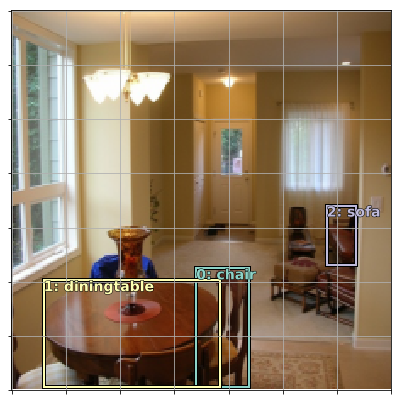

In [231]:
fig, ax = plt.subplots(figsize = (7,7))
torch_gt(ax,ima, bbox, clas)

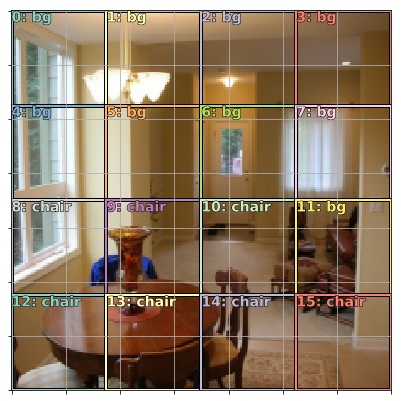

In [232]:
fig, ax = plt.subplots(figsize = (7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [233]:
grid_sizes

Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [234]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [235]:
a_ic = actn_to_bb(b_bboxi, anchors)

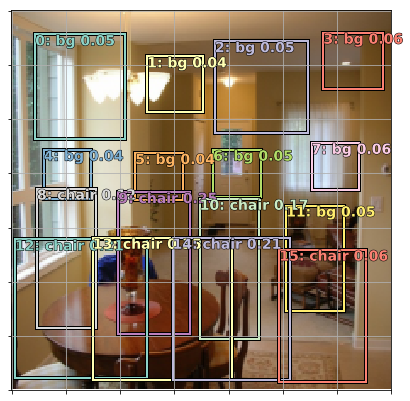

In [236]:
fig, ax = plt.subplots(figsize = (7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [237]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0091
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0356  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.0922  0.0000  0.0000  0.0315  0.3985  0.0000
 0.0103  0.0000  0.2598  0.4538  0.0653  0.0000
 0.0000  0.1897  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

In [238]:
overlaps.max(1)

(
  0.3985
  0.4538
  0.1897
 [torch.cuda.FloatTensor of size 3 (GPU 0)], 
  14
  13
  11
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [239]:
overlaps.max(0)

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  0.1897
  0.2598
  0.4538
  0.3985
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [240]:
gt_overlap, gt_idx = map_to_ground_truth(overlaps)
gt_overlap, gt_idx

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  1.9900
  0.2598
  1.9900
  1.9900
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [241]:
gt_clas = clas[gt_idx]; gt_clas

Variable containing:
  8
  8
  8
  8
  8
  8
  8
  8
 10
 10
  8
 17
 10
 10
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]

In [242]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx


 11
 13
 14
[torch.cuda.LongTensor of size 3 (GPU 0)]

In [244]:
pos


 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 1
 1
 0
[torch.cuda.ByteTensor of size 16 (GPU 0)]

In [246]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o < len(id2cat) else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']

In [248]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss = F.cross_entropy(b_clasi, gt_clas)
loc_loss, clas_loss

(Variable containing:
 1.00000e-02 *
   6.7785
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.9012
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


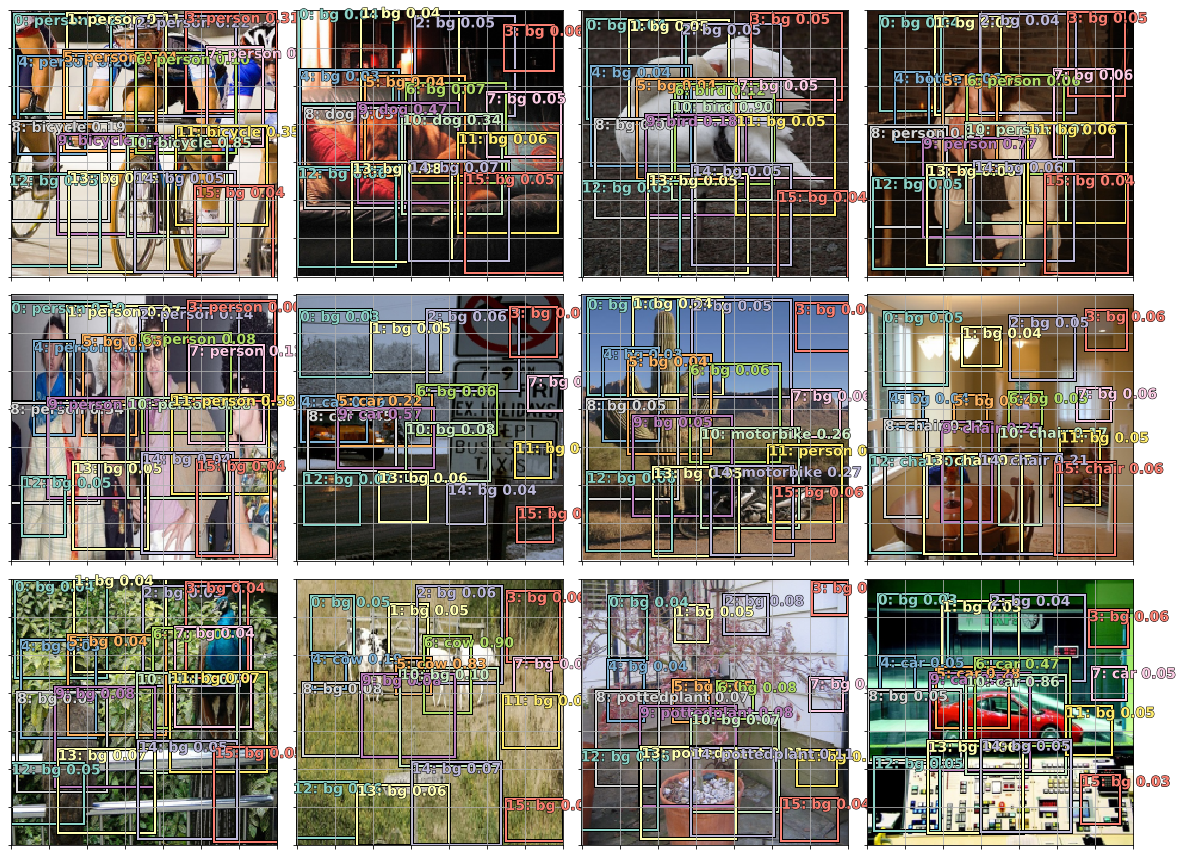

In [251]:
fig, axes = plt.subplots(3, 4, figsize = (16, 12))
for idx, ax in enumerate(axes.flat):
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox, clas = get_y(y[0][idx], y[1][idx])
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox, clas = get_y(bbox, clas); bbox, clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()